In [19]:
import os
import sys
sys.path.append('..\..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.signal import medfilt
import pickle
from utils.plotting import calculate_error_bars
from set_global_params import out_of_task_mice, running_in_box_dir, reproduce_figures_path, spreadsheet_path
%matplotlib notebook

In [2]:
# analysis params 
movement_threshold_stds = 0.5
min_duration_samples = 2
save_dir = os.path.join(reproduce_figures_path, 'ED_fig5', 'movement_outside_task') #running_in_box_dir + '\\processed_data\\'

In [3]:
# example mouse
mouse = 'SNL_photo37'
data = np.load(os.path.join(save_dir, 'preprocessed_speed_by_neurons_transformed_tracking_{}.npz'.format(mouse)), allow_pickle=True)
file = open(os.path.join(save_dir,'tracking_data_{}.p'.format(mouse)), 'rb')
transformed_data = pickle.load(file)
file.close()

In [4]:
speed = data['speed']
acc = data['acceleration']
angular_velocity = medfilt(data['head_angular_velocity'],3)
brain = data['photometry_data']
head_angles = data['head_angles']
acc[:2] = np.nan
speed[:2] = np.nan
angular_velocity[:2] = np.nan
head_angles[:2] = np.nan


samp_rate = 30
time_base = np.arange(len(brain)) / samp_rate

In [5]:
df = pd.DataFrame.from_dict({'speed': speed, 'acceleration': acc, 'signal': brain, 'time': time_base, 'angular_velocity': angular_velocity,
                            'head_angles': head_angles})

In [6]:
midpoints_y = (transformed_data['L_ear']['y'] + transformed_data['R_ear']['y']) / 2
midpoints_x = (transformed_data['L_ear']['x'] + transformed_data['R_ear']['x']) / 2
nose_x = transformed_data['nose']['x']
nose_y = transformed_data['nose']['y']


<IPython.core.display.Javascript object>


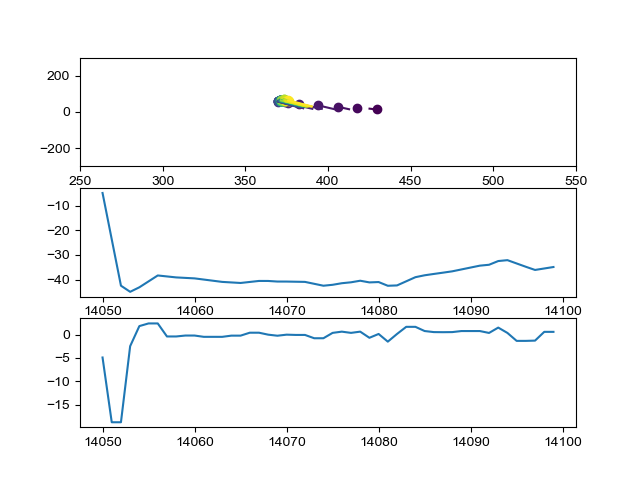

(250.0, 550.0)

In [7]:
fig, axs = plt.subplots(3)
start_frame = 14050
num_frames = 50
colours = matplotlib.cm.viridis(np.linspace(0, 1, num_frames))
for frame in range(start_frame, start_frame + num_frames):
    axs[0].plot([nose_x[frame], midpoints_x[frame]], [nose_y[frame], midpoints_y[frame]], color=colours[frame-start_frame])
    axs[0].scatter(nose_x[frame], nose_y[frame], color=colours[frame-start_frame])
axs[1].plot(np.cumsum(df.angular_velocity[start_frame: start_frame + num_frames]))
axs[2].plot(df.angular_velocity[start_frame: start_frame + num_frames])
axs[0].set_ylim([-300, 300])
axs[0].set_xlim([250, 550])

In [8]:
var = 'angular_velocity'
if mouse != 'SNL_photo44': # has fiber on the other side
    moving_clockwise = df[var] >= movement_threshold_stds * np.nanstd(df[var])
    moving_clockwise = binary_erosion(moving_clockwise, np.ones(min_duration_samples))
    moving_clockwise = binary_dilation(moving_clockwise, np.ones(min_duration_samples))
    diff_moving_clockwise  = np.append(np.diff(moving_clockwise.astype(int)),0)
    movement_starts = np.where((moving_clockwise == 0) & (diff_moving_clockwise ==1))[0]
    moving_anticlockwise = df[var] <= -1 * movement_threshold_stds * np.nanstd(df[var])
    moving_anticlockwise = binary_erosion(moving_anticlockwise, np.ones(min_duration_samples))
    moving_anticlockwise = binary_dilation(moving_anticlockwise, np.ones(min_duration_samples))
    diff_moving_anticlockwise  = np.append(np.diff(moving_anticlockwise.astype(int)),0)
    movement_stops = np.where((moving_anticlockwise == 0) & (diff_moving_anticlockwise == 1))[0]
else:
    moving_clockwise = df[var] >= movement_threshold_stds * np.nanstd(df[var])
    moving_clockwise = binary_erosion(moving_clockwise, np.ones(min_duration_samples))
    moving_clockwise = binary_dilation(moving_clockwise, np.ones(min_duration_samples))
    diff_moving_clockwise  = np.append(np.diff(moving_clockwise.astype(int)),0)
    movement_stops = np.where((moving_clockwise == 0) & (diff_moving_clockwise ==1))[0]
    moving_anticlockwise = df[var] <= -1 * movement_threshold_stds * np.nanstd(df[var])
    moving_anticlockwise = binary_erosion(moving_anticlockwise, np.ones(min_duration_samples))
    moving_anticlockwise = binary_dilation(moving_anticlockwise, np.ones(min_duration_samples))
    diff_moving_anticlockwise  = np.append(np.diff(moving_anticlockwise.astype(int)),0)
    movement_starts = np.where((moving_anticlockwise == 0) & (diff_moving_anticlockwise == 1))[0]

<IPython.core.display.Javascript object>


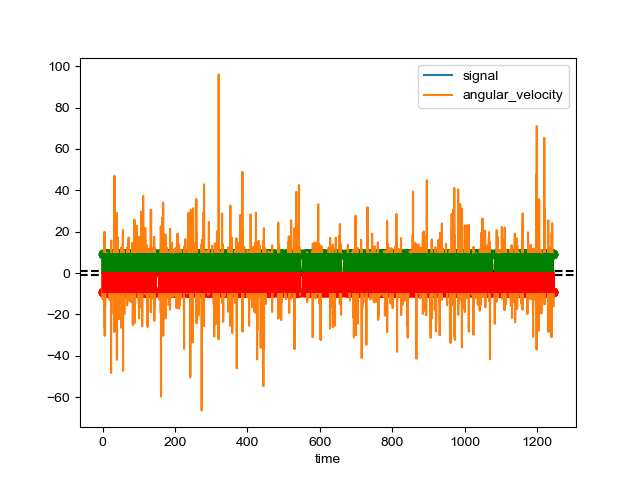

In [9]:
df.plot(x='time', y=['signal', 'angular_velocity'])
#plt.xlim([400, 410])
plt.axhline(movement_threshold_stds * np.nanstd(speed), linestyle='--', color='k')
plt.axhline(-1 * movement_threshold_stds * np.nanstd(speed), linestyle='--', color='k')

if mouse != 'SNL_photo44':
    ipsi_contra_switch = 1
else:
    ipsi_contra_switch = -1
plt.plot(df['time'], moving_clockwise*9 * ipsi_contra_switch, color='g')
plt.plot(df['time'], moving_anticlockwise*-9 * ipsi_contra_switch, color='r')
plt.scatter(df.time.values[movement_starts],  ipsi_contra_switch * 9* np.ones(df.time.values[movement_starts].shape), color='g')
plt.scatter(df.time.values[movement_stops],  ipsi_contra_switch * -9* np.ones(df.time.values[movement_stops].shape), color='r')

In [10]:
def find_nearest_next_diff(array, value):
    diff_array = np.asarray(array - value)
    idx =  np.where(diff_array > 0, diff_array, np.inf).argmin()
    return diff_array[idx]

In [11]:
def find_nearest_previous_diff(array, value):
    diff_array = np.asarray(array - value)
    idx =  np.where(diff_array < 0, diff_array, -np.inf).argmax()
    return abs(diff_array[idx])

In [12]:
# removes movements in window where there is no photometry
cutoff = np.max(np.where(np.isnan(brain))) + 50
movement_starts = movement_starts[(movement_starts > cutoff) & (movement_starts < df.signal.shape[0] - cutoff)]
movement_stops = movement_stops[(movement_stops > cutoff) & (movement_stops < df.signal.shape[0] - cutoff)]

In [13]:
t = 15
valid_movement_starts = np.array([start for start in movement_starts if (find_nearest_previous_diff(movement_stops, start) > t) & (find_nearest_next_diff(movement_stops, start) > t)])
valid_movement_stops = np.array([stop for stop in movement_stops if (find_nearest_next_diff(movement_starts, stop) > t) & (find_nearest_previous_diff(movement_starts, stop) > t)])

<IPython.core.display.Javascript object>


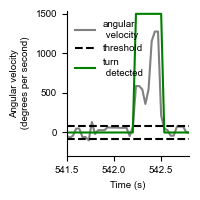

In [16]:
font = {'size': 7}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']

fig, ax = plt.subplots(figsize=[2,2])
ax.plot(df['time'], df['angular_velocity']*30, color='gray', label='angular\n velocity')
#plt.xlim([400, 410])
ax.axhline(movement_threshold_stds * np.nanstd(df[var]*30), linestyle='--', color='k', label='threshold')
ax.axhline(-movement_threshold_stds * np.nanstd(df[var]*30), linestyle='--', color='k')
if mouse != 'SNL_photo44':
    ipsi_contra_switch = 1
else:
    ipsi_contra_switch = -1

ax.plot(df['time'], moving_clockwise*50*30 * ipsi_contra_switch, color='g', label='turn\n detected')
#ax.plot(df['time'], moving_anticlockwise*-9 * ipsi_contra_switch, color='r')
#ax.scatter(df.time.values[valid_movement_starts], df.angular_velocity[valid_movement_starts], color='g')
#ax.scatter(df.time.values[valid_movement_stops],  ipsi_contra_switch * -9* np.ones(df.time.values[valid_movement_stops].shape), color='r')
ax.set_xlim([541.5, 542.8])
ax.set_ylim([-10*30, 51*30])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(frameon=False, loc='upper left')

ax.set_ylabel('Angular velocity\n (degrees per second)')
ax.set_xlabel('Time (s)')
plt.tight_layout()


<IPython.core.display.Javascript object>


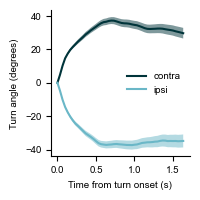

In [17]:

fig, ax = plt.subplots(figsize=[2,2])
turn_traces = np.ones((valid_movement_starts.shape[0], 50))
turn_speeds = np.ones((valid_movement_starts.shape[0], 50))
for turn in range(valid_movement_starts.shape[0]):
    turn_traces[turn, :] = df.signal[valid_movement_starts[turn]: valid_movement_starts[turn] + 50]
    turn_speeds[turn, :] = np.cumsum(df.angular_velocity [valid_movement_starts[turn]: valid_movement_starts[turn] + 50]) - df.angular_velocity[valid_movement_starts[turn]]
ax.plot(np.arange(50)/30, np.nanmean(turn_speeds, axis=0), color='#00343A', label='contra')
contra_err_lower, contra_err_upper = calculate_error_bars(np.nanmean(turn_speeds, axis=0), turn_speeds)
ax.fill_between(np.arange(50)/30, contra_err_lower, contra_err_upper, alpha=0.5, facecolor='#00343A', linewidth=0)

turn_traces = np.ones((valid_movement_stops.shape[0], 50))
turn_speeds = np.ones((valid_movement_stops.shape[0], 50))
for turn in range(valid_movement_stops.shape[0]):
    turn_traces[turn, :] = df.signal[valid_movement_stops[turn]: valid_movement_stops[turn] + 50]
    turn_speeds[turn, :] = np.cumsum(df.angular_velocity[valid_movement_stops[turn]: valid_movement_stops[turn] + 50]) - df.angular_velocity[valid_movement_stops[turn]]
ax.plot(np.arange(50)/30, np.nanmean(turn_speeds, axis=0), color='#6AB7C7', label='ipsi')
ipsi_err_lower, ipsi_err_upper = calculate_error_bars(np.nanmean(turn_speeds, axis=0), turn_speeds)
ax.fill_between(np.arange(50)/30, ipsi_err_lower, ipsi_err_upper, alpha=0.5, facecolor='#6AB7C7', linewidth=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Turn angle (degrees)')
ax.set_xlabel('Time from turn onset (s)')
plt.legend(frameon=False)
plt.tight_layout()

plt.show()

In [20]:
time_points = (np.arange(100) - 50)/30

In [30]:
# save out traces for example mouse to csv
spreadsheet_file_path = os.path.join(spreadsheet_path, 'ED_fig5')
if not os.path.exists(os.path.join(spreadsheet_file_path, 'ED_fig5I_example_ipsi_traces.csv')):
    df_for_spreadsheet = pd.DataFrame(ipsi_turn_traces.T)
    df_for_spreadsheet.insert(0, "Timepoints", time_points)
    df_for_spreadsheet.to_csv(os.path.join(spreadsheet_file_path, 'ED_fig5I_example_ipsi_traces.csv'))
spreadsheet_file_path = os.path.join(spreadsheet_path, 'ED_fig5')
if not os.path.exists(os.path.join(spreadsheet_file_path, 'ED_fig5I_example_contra_traces.csv')):
    df_for_spreadsheet = pd.DataFrame(contra_turn_traces.T)
    df_for_spreadsheet.insert(0, "Timepoints", time_points)
    df_for_spreadsheet.to_csv(os.path.join(spreadsheet_file_path, 'ED_fig5I_example_contra_traces.csv'))


<IPython.core.display.Javascript object>


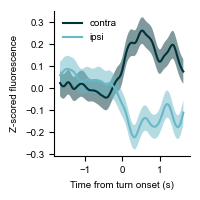

In [21]:
font = {'size': 7}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


fig, ax = plt.subplots(figsize=[2,2])
contra_turn_traces = np.ones((valid_movement_starts.shape[0], 100))
for turn in range(valid_movement_starts.shape[0]):
    contra_turn_traces[turn, :] = df.signal[valid_movement_starts[turn] - 50: valid_movement_starts[turn] + 50]

contra_err_lower, contra_err_upper = calculate_error_bars(np.nanmean(contra_turn_traces, axis=0), contra_turn_traces)
ax.plot(time_points, np.nanmean(contra_turn_traces, axis=0), color='#00343A', label='contra')
ax.fill_between(time_points, contra_err_lower, contra_err_upper, alpha=0.5, facecolor='#00343A', linewidth=0)
ipsi_turn_traces = np.ones((valid_movement_stops.shape[0], 100))
for turn in range(valid_movement_stops.shape[0]):
    ipsi_turn_traces[turn, :] = df.signal[valid_movement_stops[turn] - 50: valid_movement_stops[turn] + 50]
ipsi_err_lower, ipsi_err_upper = calculate_error_bars(np.nanmean(ipsi_turn_traces, axis=0), ipsi_turn_traces)
ax.plot(time_points, np.nanmean(ipsi_turn_traces, axis=0), color='#6AB7C7', label='ipsi')
ax.fill_between(time_points, ipsi_err_lower, ipsi_err_upper, alpha=0.5, facecolor='#6AB7C7', linewidth=0)
ax.set_xlabel('Time from turn onset (s)')
ax.set_ylabel('Z-scored fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [13]:
# now run it for all mice and save out contr and ipsi turn traces
for mouse in out_of_task_mice:
    data = np.load(os.path.join(save_dir, 'preprocessed_speed_by_neurons_transformed_tracking_{}.npz'.format(mouse)), allow_pickle=True)
    file = open(os.path.join(save_dir,'tracking_data_{}.p'.format(mouse)), 'rb')
    transformed_data = pickle.load(file)
    file.close()
    
    speed = data['speed']
    acc = data['acceleration']
    angular_velocity = medfilt(data['head_angular_velocity'],3)
    brain = data['photometry_data']
    head_angles = data['head_angles']
    acc[:2] = np.nan
    speed[:2] = np.nan
    angular_velocity[:2] = np.nan
    head_angles[:2] = np.nan
    samp_rate = 30
    time_base = np.arange(len(brain)) / samp_rate
    df = pd.DataFrame.from_dict({'speed': speed, 'acceleration': acc, 'signal': brain, 'time': time_base, 'angular_velocity': angular_velocity,
                            'head_angles': head_angles})
    
    midpoints_y = (transformed_data['L_ear']['y'] + transformed_data['R_ear']['y']) / 2
    midpoints_x = (transformed_data['L_ear']['x'] + transformed_data['R_ear']['x']) / 2
    nose_x = transformed_data['nose']['x']
    nose_y = transformed_data['nose']['y']
    
    var = 'angular_velocity'
    if mouse != 'SNL_photo44':
        moving_clockwise = df[var] >= movement_threshold_stds * np.nanstd(df[var])
        moving_clockwise = binary_erosion(moving_clockwise, np.ones(min_duration_samples))
        moving_clockwise = binary_dilation(moving_clockwise, np.ones(min_duration_samples))
        diff_moving_clockwise  = np.append(np.diff(moving_clockwise.astype(int)),0)
        movement_starts = np.where((moving_clockwise == 0) & (diff_moving_clockwise ==1))[0]
        moving_anticlockwise = df[var] <= -1 * movement_threshold_stds * np.nanstd(df[var])
        moving_anticlockwise = binary_erosion(moving_anticlockwise, np.ones(min_duration_samples))
        moving_anticlockwise = binary_dilation(moving_anticlockwise, np.ones(min_duration_samples))
        diff_moving_anticlockwise  = np.append(np.diff(moving_anticlockwise.astype(int)),0)
        movement_stops = np.where((moving_anticlockwise == 0) & (diff_moving_anticlockwise == 1))[0]
    else:
        moving_clockwise = df[var] >= movement_threshold_stds * np.nanstd(df[var])
        moving_clockwise = binary_erosion(moving_clockwise, np.ones(min_duration_samples))
        moving_clockwise = binary_dilation(moving_clockwise, np.ones(min_duration_samples))
        diff_moving_clockwise  = np.append(np.diff(moving_clockwise.astype(int)),0)
        movement_stops = np.where((moving_clockwise == 0) & (diff_moving_clockwise ==1))[0]
        moving_anticlockwise = df[var] <= -1 * movement_threshold_stds * np.nanstd(df[var])
        moving_anticlockwise = binary_erosion(moving_anticlockwise, np.ones(min_duration_samples))
        moving_anticlockwise = binary_dilation(moving_anticlockwise, np.ones(min_duration_samples))
        diff_moving_anticlockwise  = np.append(np.diff(moving_anticlockwise.astype(int)),0)
        movement_starts = np.where((moving_anticlockwise == 0) & (diff_moving_anticlockwise == 1))[0]

    # removes movements in window where there is no photometry
    cutoff = np.max(np.where(np.isnan(brain))) + 50
    movement_starts = movement_starts[(movement_starts > cutoff) & (movement_starts < df.signal.shape[0] - cutoff)]
    movement_stops = movement_stops[(movement_stops > cutoff) & (movement_stops < df.signal.shape[0] - cutoff)]
    
    t = 15
    valid_movement_starts = np.array([start for start in movement_starts if (find_nearest_previous_diff(movement_stops, start) > t) & (find_nearest_next_diff(movement_stops, start) > t)])
    valid_movement_stops = np.array([stop for stop in movement_stops if (find_nearest_next_diff(movement_starts, stop) > t) & (find_nearest_previous_diff(movement_starts, stop) > t)])

    contra_turn_traces = np.ones((valid_movement_starts.shape[0], 100))
    for turn in range(valid_movement_starts.shape[0]):
        contra_turn_traces[turn, :] = df.signal[valid_movement_starts[turn] - 50: valid_movement_starts[turn] + 50]
    ipsi_turn_traces = np.ones((valid_movement_stops.shape[0], 100))
    for turn in range(valid_movement_stops.shape[0]):
        ipsi_turn_traces[turn, :] = df.signal[valid_movement_stops[turn] - 50: valid_movement_stops[turn] + 50]
    np.savez(os.path.join(save_dir,'ipsi_contra_turn_traces_{}'.format(mouse)), ipsi=ipsi_turn_traces, contra=contra_turn_traces)

In [24]:
mice = out_of_task_mice
for i, mouse in enumerate(mice):
    data = np.load(os.path.join(save_dir,'ipsi_contra_turn_traces_{}.npz'.format(mouse)))
    ipsi = data['ipsi']
    contra = data['contra']
    if i == 0:
        group_ipsi_data = np.mean(ipsi, axis=0)
        group_contra_data = np.mean(contra, axis=0)
    else:
        group_ipsi_data = np.vstack([group_ipsi_data, np.mean(ipsi, axis=0)])
        group_contra_data = np.vstack([group_contra_data, np.mean(contra, axis=0)])

In [28]:
# save group traces out to a csv 
spreadsheet_file_path = os.path.join(spreadsheet_path, 'ED_fig5')
if not os.path.exists(os.path.join(spreadsheet_file_path, 'ED_fig5J_group_ipsi_traces.csv')):
    df_for_spreadsheet = pd.DataFrame(group_ipsi_data.T)
    df_for_spreadsheet.insert(0, "Timepoints", time_points)
    df_for_spreadsheet.to_csv(os.path.join(spreadsheet_file_path, 'ED_fig5J_group_ipsi_traces.csv'))
spreadsheet_file_path = os.path.join(spreadsheet_path, 'ED_fig5')
if not os.path.exists(os.path.join(spreadsheet_file_path, 'ED_fig5J_group_contra_traces.csv')):
    df_for_spreadsheet = pd.DataFrame(group_contra_data.T)
    df_for_spreadsheet.insert(0, "Timepoints", time_points)
    df_for_spreadsheet.to_csv(os.path.join(spreadsheet_file_path, 'ED_fig5J_group_contra_traces.csv'))


<IPython.core.display.Javascript object>


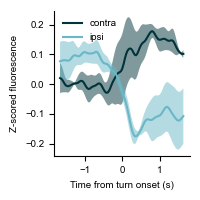

In [15]:
font = {'size': 7}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


fig, ax = plt.subplots(figsize=[2,2])

contra_err_lower, contra_err_upper = calculate_error_bars(np.nanmean(group_contra_data, axis=0), group_contra_data)
ax.plot(time_points, np.nanmean(group_contra_data, axis=0), color='#00343A', label='contra')
ax.fill_between(time_points, contra_err_lower, contra_err_upper, alpha=0.5, facecolor='#00343A', linewidth=0)

ipsi_err_lower, ipsi_err_upper = calculate_error_bars(np.nanmean(group_ipsi_data, axis=0), group_ipsi_data)
ax.plot(time_points, np.nanmean(group_ipsi_data, axis=0), color='#6AB7C7', label='ipsi')
ax.fill_between(time_points, ipsi_err_lower, ipsi_err_upper, alpha=0.5, facecolor='#6AB7C7', linewidth=0)
ax.set_xlabel('Time from turn onset (s)')
ax.set_ylabel('Z-scored fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()